## Script for model comparison
Modely trenovane na malej random vzorke dat, vyhodnotene

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [4]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

In [5]:
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()
data_sample = data.sample(n=50000)
list(data_sample.columns)

['index',
 'id',
 'curve',
 'primary__t_eff',
 'secondary__t_eff',
 'inclination',
 'mass_ratio',
 'primary__surface_potential',
 'secondary__surface_potential',
 't1_t2',
 'filter',
 'critical_surface_potential',
 'primary__equivalent_radius',
 'secondary__equivalent_radius',
 'primary__filling_factor',
 'secondary__filling_factor']

In [6]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

In [7]:
y = np.array(data_sample[[
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2"]])

In [8]:
# MinMax Scaler
scaler = MinMaxScaler()
y_minmax_scaled = scaler.fit_transform(y)
y_minmax_scaled[0]

array([0.71584635, 0.05050505, 0.17208073, 0.0020424 , 0.7804878 ])

In [9]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y_minmax_scaled, test_size=0.2)

In [10]:
# Adding noise to train data
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

In [11]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train_n),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  50000 
Number of train data without noise:  40000 
Number of train data with noise:  120000 
Number of test data without noise:  10000


## Model v1
Povodny model

In [14]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(5, activation='linear')(x)
model_v1 = Model(inputs=inputs, outputs=output)
model_v1.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_v1.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 199, 64)           33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12736)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [15]:
saved_model = "det_models_comparison/norm_detached_sel_v1.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [16]:
history = model_v1.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.1035 - mape: 2189551.0000
Epoch 00001: val_mae improved from inf to 0.09551, saving model to det_models_comparison\norm_detached_sel_v1.hdf5
1688/1688 [==============================] - 331s 196ms/step - loss: 0.0294 - mae: 0.1035 - mape: 2189551.0000 - val_loss: 0.0244 - val_mae: 0.0955 - val_mape: 1854928.8750
Epoch 2/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0240 - mae: 0.0908 - mape: 1887564.3750
Epoch 00002: val_mae improved from 0.09551 to 0.08438, saving model to det_models_comparison\norm_detached_sel_v1.hdf5
1688/1688 [==============================] - 280s 166ms/step - loss: 0.0240 - mae: 0.0908 - mape: 1887564.3750 - val_loss: 0.0231 - val_mae: 0.0844 - val_mape: 1388718.1250
Epoch 3/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0220 - mae: 0.0857 - mape: 1899570.3750
Epoch 00003: val_mae improved from 0.08438 to 0.08254, saving model to det_mod

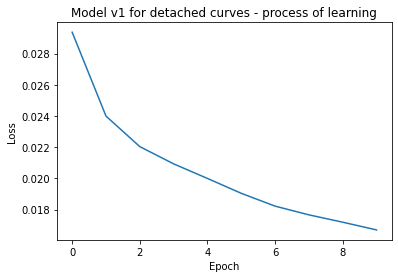

In [17]:
plt.plot(history.history['loss'])
plt.title("Model v1 for detached curves - process of learning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("det_models_comparison/model_v1.jpg")

## Model v2
Pridana CNN vrstva + zmenene neurony na CNN vrstvach

In [18]:
inputs = Input(shape=(400, 1))
b = Conv1D(128, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(64, kernel_size = 3, padding = "valid")(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(5, activation='linear')(x)
model_v2 = Model(inputs=inputs, outputs=output)
model_v2.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_v2.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 398, 128)          512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 197, 64)           24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 197, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 197, 64)           33024     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12608)            

In [19]:
saved_model = "det_models_comparison/norm_detached_sel_v2.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [21]:
history2 = model_v2.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0136 - mae: 0.0621 - mape: 1579192.6250
Epoch 00001: val_mae improved from 0.06175 to 0.05943, saving model to det_models_comparison\norm_detached_sel_v2.hdf5
1688/1688 [==============================] - 370s 219ms/step - loss: 0.0136 - mae: 0.0621 - mape: 1579192.6250 - val_loss: 0.0134 - val_mae: 0.0594 - val_mape: 1188060.1250
Epoch 2/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0132 - mae: 0.0608 - mape: 1552603.2500
Epoch 00002: val_mae improved from 0.05943 to 0.05872, saving model to det_models_comparison\norm_detached_sel_v2.hdf5
1688/1688 [==============================] - 373s 221ms/step - loss: 0.0132 - mae: 0.0608 - mape: 1552603.2500 - val_loss: 0.0130 - val_mae: 0.0587 - val_mape: 1182588.6250
Epoch 3/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0594 - mape: 1481736.0000
Epoch 00003: val_mae improved from 0.05872 to 0.05808, saving model to det

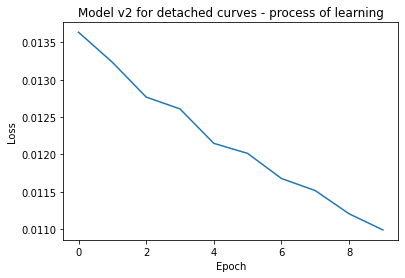

In [22]:
plt.plot(history2.history['loss'])
plt.title("Model v2 for detached curves - process of learning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("det_models_comparison/model_v2.jpg")

## Model v3
Pridana lstm vrstva + maxpooling vrstva po cnn + zmensena batch size

In [ ]:
inputs = Input(shape=(400, 1))
b = Conv1D(128, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(64, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(5, activation='linear')(x)
model_v3 = Model(inputs=inputs, outputs=output)
model_v3.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_v3.summary())

In [ ]:
saved_model = "det_models_comparison/norm_detached_sel_v3.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [ ]:
history3 = model_v3.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 32)

In [ ]:
plt.plot(history3.history['loss'])
plt.title("Model v3 for detached curves - process of learning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("det_models_comparison/model_v3.jpg")

## Model v4
architektura v3 - pridane neurony na 2. cnn vrstve, zmensena batch size

In [ ]:
inputs = Input(shape=(400, 1))
b = Conv1D(128, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(128, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(5, activation='linear')(x)
model_v4 = Model(inputs=inputs, outputs=output)
model_v4.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_v4.summary())

In [ ]:
saved_model = "det_models_comparison/norm_detached_sel_v4.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [ ]:
history4 = model_v4.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 32)

In [ ]:
plt.plot(history4.history['loss'])
plt.title("Model v4 for detached curves - process of learning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("det_models_comparison/model_v4.jpg")

## Model v5
v4 architektura + lstm vrstvy s upravenymi poctami neuronov

In [ ]:
inputs = Input(shape=(400, 1))
b = Conv1D(128, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(128, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(128, return_sequences=True)(b)
b = LSTM(64, return_sequences=True)(b)
b = LSTM(64, return_sequences=True)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(5, activation='linear')(x)
model_v5 = Model(inputs=inputs, outputs=output)
model_v5.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_v5.summary())

In [ ]:
saved_model = "det_models_comparison/norm_detached_sel_v5.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [ ]:
history5 = model_v5.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 32)

In [ ]:
plt.plot(history5.history['loss'])
plt.title("Model v5 for detached curves - process of learning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("det_models_comparison/model_v4.jpg")